## superresolution

### imports

In [ ]:
import os
!pip install matplotlib dill scikit-image pillow
os._exit(00) #restart notebook

In [65]:
run_on_google_colab = False #use PlaidML as Backend, change this to 'True' to run on colab/tf
import os
if run_on_google_colab:
    %cd /content
    !git clone https://github.com/BenjaminWegener/superresolution #download Dataset
    %cd superresolution
    import tensorflow as tf
    from tensorflow.keras.models import Model, load_model
    from tensorflow.keras.layers import *
    from tensorflow.keras.optimizers import Adam
    from tensorflow.keras import backend as K
    from tensorflow.keras.callbacks import LambdaCallback
    from tensorflow.keras.applications.vgg16 import VGG16
else:
    os.environ['KERAS_BACKEND'] = 'plaidml.keras.backend'
    from keras.models import Model, load_model
    from keras.layers import *
    from keras.optimizers import Adam
    from keras import backend as K
    from keras import layers as L
    from keras import models as M
    from keras import utils as U
    from keras.callbacks import LambdaCallback
    from keras.applications.vgg16 import VGG16

import numpy as np
from IPython.display import clear_output
import matplotlib.pyplot as plt
%matplotlib inline
from keras.preprocessing.image import ImageDataGenerator
from math import isnan
import random
import dill
import time
from PIL import Image
from skimage.transform import resize
from contextlib import contextmanager
import sys
@contextmanager
def silence_stdout():
    new_target = open(os.devnull, "w")
    old_target = sys.stdout
    sys.stdout = new_target
    try:
        yield new_target
    finally:
        sys.stdout = old_target   

### options


In [66]:
train_separator = True
train_lossmodel = True
separator_epochs = 150
loss_model_epochs = 2000
epochs = 5000 #Number of epochs to train
scale = 4 #How much should we upscale images
steps_per_epoch = 100 # 20
channels = 3 #channels of low resolution image
batch_size = 8 #what batch-size should we use (decrease if you encounter video memory errors)
height_lr = 128 #height of low resolution image
width_lr = height_lr #width of low resolution image
learning_rate = 0.0001 #learning rate
logging_steps = steps_per_epoch #how often to update the training log
separator_weight_file = 'sr_4x_separator_weights' #name of weight file
loss_model_weight_file = 'sr_4x_loss_model_weights'
generator_weight_file = 'sr_4x_generator_weights' #name of weight file
generator_optimizer_weight_file = 'sr_4x_generator_optimizer_weights' #name of weight file
batch_file = 'batch'

### functions for image visualization

In [67]:
def show(tensors, normalize = True):
    plt.rcParams['figure.figsize'] = [20, 10]
    fig = plt.figure()
    for i in range(len(tensors)):
        cmap = 'gray'
        try:
            tensors[i] = np.squeeze(tensors[i], axis = 0)
        except:
            pass
        try:
            tensors[i] = np.squeeze(tensors[i], axis = 2)
        except:
            pass
        try:    
            depth = tensors[i].shape[2]
            cmap = None
        except:
            pass
        if normalize:
            tensors[i] = tensors[i] * 255
        tensors[i] = np.clip(tensors[i], 0, 255)
        fig.add_subplot(1, len(tensors), i + 1)
        plt.imshow(tensors[i].astype(np.uint8), cmap = cmap, interpolation = 'spline36')
        #plt.imshow(tensors[i].astype(np.uint8).squeeze(axis=2), cmap='gray', interpolation = 'spline36')
    plt.setp(plt.gcf().get_axes(), xticks=[], yticks=[]);
    plt.show()

In [68]:
# show image in actual size https://stackoverflow.com/a/42314798/
def display_image_in_actual_size(im_data):
    try:
        im_data = np.squeeze(im_data, axis = 0)
    except:
        pass 
    im_data = np.clip(im_data, 0, 255)
    dpi = 100
    print(im_data.shape)
    height = im_data.shape[0]
    width = im_data.shape[1]
    figsize = width / float(dpi), height / float(dpi)
    fig = plt.figure(figsize=figsize)
    ax = fig.add_axes([0, 0, 1, 1])
    ax.axis('off')
    ax.imshow(im_data.astype(np.uint8), interpolation = 'spline36')

### initialize tpu backend if using google colab

In [69]:
if run_on_google_colab:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    print('Running on TPU ', tpu.cluster_spec().as_dict()['worker'])
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
    print("REPLICAS: ", strategy.num_replicas_in_sync)

### dataset function for separator

In [70]:
# return batch of augmented train and target images with quantity n_samples
def get_batch_separator(n_samples, height, width):
    # define a ImageGenerator instance from keras with augmentations
    image_gen = ImageDataGenerator(rotation_range = 359,
                           width_shift_range = 2,
                           height_shift_range = 2,
                           zoom_range = [0.25, 0.8],
                           shear_range = 0.1,
                           horizontal_flip = True,
                           vertical_flip = True,
                           fill_mode = 'reflect',
                           data_format = 'channels_last',
                           #interpolation_order = 5,
                           #interpolation = 'bicubic',
                           brightness_range = [0.5, 1.5])
    #seed for random augmentations
    random_seed = int(random.random() * 100000)
    #generate augmented images
    with silence_stdout():
        y1_train = image_gen.flow_from_directory('.', 
                                                target_size = (height, width), 
                                                batch_size = n_samples, 
                                                class_mode = None,
                                                interpolation = 'lanczos', 
                                                seed = random_seed)
        y1_train = y1_train.__getitem__(0).copy() #fix for 'array doesn't own its data'
        x_train = np.empty((len(y1_train), height, width, 3))
        y3_train = np.empty((len(y1_train), height, width, 3))
    y2_train = np.dot(y1_train[...,:3], [0.33, 0.33, 0.33])
    y2_train = np.expand_dims(y2_train, axis = -1)
    y3_train = np.subtract(y1_train, y2_train)
    for i in range(n_samples):
        x_train[i] = y1_train[i]
    return x_train / 255, y1_train /255, y2_train / 255, y3_train / 255

### build separator

In [71]:
def build_separator():
    inputs = Input(shape = (height_lr, width_lr, channels))
    gray = SeparableConv2D(1, 1, padding = 'same', name = 'color_sep')(inputs)
    color = Concatenate()([gray, inputs])
    color = SeparableConv2D(3, 1, padding = 'same', name = 'color_sub')(color)
    outputs = Add()([color, gray])
    return Model(inputs = inputs, outputs = [outputs, gray, color])

### define separator callback

In [72]:
def logging_separator(epoch, logs):
    global this_time
    if (epoch % 200 == 0) and (epoch > 0):
        last_time = this_time
        this_time = time.time()

        clear_output()
        print('epoch', real_epoch + 1, '/', separator_epochs, '--> step', (epoch), '/200', '| loss:', logs['loss'], '| time taken:', this_time - last_time
             )
        '''
        TFLITE_MODEL = "superresolution_4x_tflite_convatt_separator.tflite"
        run_model = tf.function(lambda x : separator(x))
        concrete_func = run_model.get_concrete_function(tf.TensorSpec(separator.inputs[0].shape, separator.inputs[0].dtype))
        converter = tf.lite.TFLiteConverter.from_concrete_functions([concrete_func])
        #converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS, tf.lite.OpsSet.SELECT_TF_OPS]
        converted_tflite_model = converter.convert()
        open(TFLITE_MODEL, "wb").write(converted_tflite_model)
        tflite_separator_interpreter = tf.lite.Interpreter(model_path=TFLITE_MODEL)
        '''
        testX, testY1, testY2, testY3 = get_batch_separator(1, height_lr, width_lr)
        '''
        input_details = tflite_separator_interpreter.get_input_details()
        output_details = tflite_separator_interpreter.get_output_details()
        tflite_separator_interpreter.allocate_tensors()
        tflite_separator_interpreter.set_tensor(input_details[0]['index'], testX.astype(np.float32))
        tflite_separator_interpreter.invoke()
        predY = tflite_separator_interpreter.get_tensor(output_details[0]['index'])
        predZ = tflite_separator_interpreter.get_tensor(output_details[1]['index'])
        '''
        predY1, predY2, predY3 = separator.predict(testX)
        show([testX[0], testY1[0], predY1[0], testY2[0], predY2[0], testY3[0], predY3[0]])

separator_logging_callback = LambdaCallback(on_epoch_end = lambda epoch, logs: logging_separator(epoch, logs))

### compile separator

In [73]:
if run_on_google_colab:
    with strategy.scope():
        separator = build_separator()
        separator.compile(optimizer = Adam(learning_rate), loss = 'mae')
        separator.summary()
else:
    separator = build_separator()
    separator.compile(optimizer = Adam(learning_rate), loss = 'mae')
    separator.summary()    

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_17 (InputLayer)           (None, 128, 128, 3)  0                                            
__________________________________________________________________________________________________
color_sep (SeparableConv2D)     (None, 128, 128, 1)  7           input_17[0][0]                   
__________________________________________________________________________________________________
concatenate_23 (Concatenate)    (None, 128, 128, 4)  0           color_sep[0][0]                  
                                                                 input_17[0][0]                   
__________________________________________________________________________________________________
color_sub (SeparableConv2D)     (None, 128, 128, 3)  19          concatenate_23[0][0]             
__________

### train separator
loss should by below 0.01

epoch 57 / 150 --> step 200 /200 | loss: 0.00015445669123437256 | time taken: 9.310104846954346


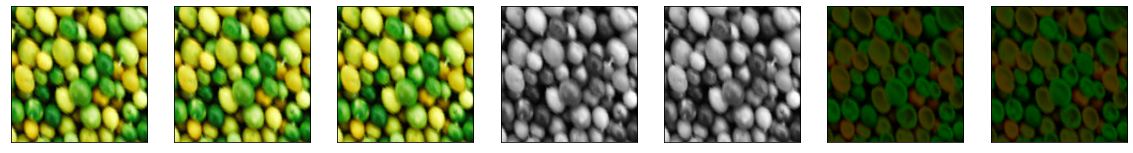

trying to save weights... success.


KeyboardInterrupt: 

In [74]:
this_time = time.time()
print('trying to load last saved weights...', end = ' ') 
try:
    with open(separator_weight_file, 'rb') as file:
        separator.set_weights(dill.load(file))
    print('success.')
except:
    print('failed.')
if train_separator:
    if run_on_google_colab:
        for real_epoch in range(separator_epochs):
            X, Y1, Y2, Y3 = get_batch_separator(batch_size, height_lr, width_lr)
            separator.fit(X, [Y1, Y2, Y3], batch_size, epochs = 201, verbose = 0, callbacks = [separator_logging_callback], shuffle = True)

            print('trying to save weights...', end = ' ')
            try:
                with open(separator_weight_file, 'wb') as file:
                    dill.dump(separator.get_weights(), file)
                print('success.')
            except:
                print('failed.')
    else:
        for real_epoch in range(separator_epochs):
            X, Y1, Y2, Y3 = get_batch_separator(batch_size, height_lr, width_lr)
            separator.fit(X, [Y1, Y2, Y3], batch_size, epochs = 201, verbose = 0, callbacks = [separator_logging_callback], shuffle = True)

            print('trying to save weights...', end = ' ')
            try:
                with open(separator_weight_file, 'wb') as file:
                    dill.dump(separator.get_weights(), file)
                print('success.')
            except:
                print('failed.')    

### save weights for generator

In [75]:
color_sep = separator.get_layer('color_sep').get_weights()
color_sub = separator.get_layer('color_sub').get_weights()
del separator

### combined perceptual and L1 loss
train a simplified fast version of vgg16 perceptual loss

In [19]:
if run_on_google_colab:
    !pip uninstall keras-applications -y
    !pip install git+https://github.com/keras-team/keras-applications.git@master
    from keras_applications.mobilenet_v3 import MobileNetV3Small
    from tensorflow.keras.applications.vgg16 import VGG16
    with strategy.scope():
        perceptual_model = VGG16(include_top=False, weights='imagenet', input_shape=(height_lr, width_lr, 3))
        perceptual_model2 = Model(inputs = perceptual_model.input, outputs = perceptual_model.get_layer('block2_conv2').output) 
        mnv3 = MobileNetV3Small(input_shape=(height_lr * scale, width_lr * scale, 3), alpha=1.0, minimalistic=True, include_top=False, weights='imagenet', backend=tf.keras.backend, layers=tf.keras.layers, models=tf.keras.models, utils=tf.keras.utils)
        loss_model_part = Model(inputs = mnv3.input, outputs = mnv3.layers[31].output)
        inputs = Input(shape = (height_lr, width_lr, channels))
        outputs = loss_model_part(inputs)
        outputs = Conv2DTranspose(128, 2, 2, padding = 'same')(outputs)
        loss_model = Model(inputs = inputs, outputs = outputs)
        loss_model.compile(optimizer = Adam(0.001), loss = 'mse')
        loss_model.summary()
else:
    from keras.applications.vgg16 import VGG16
    perceptual_model = VGG16(include_top=False, weights='imagenet', input_shape=(height_lr, width_lr, 3))
    #perceptual_model.summary()
    perceptual_model2 = Model(inputs = perceptual_model.input, outputs = perceptual_model.get_layer('block2_conv2').output) 
    del perceptual_model
    #perceptual_model2.summary()
    #mnv3 = MobileNetV3Small(input_shape=(height_lr * scale, width_lr * scale, 3), alpha = 1.0, minimalistic = True, include_top = False, weights = 'imagenet', backend = K, layers = L, models = M, utils = U)
    #mnv3.summary()
    #loss_model_part = Model(inputs = mnv3.input, outputs = mnv3.layers[25].output)
    #loss_model_part.summary()
    inputs = Input(shape = (height_lr, width_lr, channels))
    #outputs = loss_model_part(inputs)
    outputs = inputs
    att = outputs = SeparableConv2D(3, 3, padding = 'same', activation = 'relu')(outputs)
    outputs = SeparableConv2D(16, 3, padding = 'same', activation = 'relu')(outputs)
    attention = SeparableConv2D(1, 3, padding = 'same', activation = 'sigmoid')(att)
    outputs = Multiply()([outputs, attention])
    outputs = MaxPooling2D(pool_size = (2, 2), strides = 2)(outputs)
    att = outputs = SeparableConv2D(32, 3, padding = 'same', activation = 'relu')(outputs)
    outputs = SeparableConv2D(128, 3, padding = 'same', activation = 'relu')(outputs)
    attention = SeparableConv2D(1, 3, padding = 'same', activation = 'sigmoid')(att)
    outputs = Multiply()([outputs, attention])
    loss_model = Model(inputs = inputs, outputs = outputs)
    loss_model.compile(optimizer = Adam(0.0003), loss = 'mse')
    loss_model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            (None, 128, 128, 3)  0                                            
__________________________________________________________________________________________________
separable_conv2d_7 (SeparableCo (None, 128, 128, 3)  39          input_5[0][0]                    
__________________________________________________________________________________________________
separable_conv2d_8 (SeparableCo (None, 128, 128, 16) 91          separable_conv2d_7[0][0]         
__________________________________________________________________________________________________
separable_conv2d_9 (SeparableCo (None, 128, 128, 1)  31          separable_conv2d_7[0][0]         
__________________________________________________________________________________________________
multiply_3

### data generator for loss model

In [20]:
# return batch of augmented train and target images with quantity n_samples
def get_batch_loss_model(n_samples, height, width):
    # define a ImageGenerator instance from keras with augmentations
    image_gen = ImageDataGenerator(rotation_range = 359,
                           width_shift_range = 2,
                           height_shift_range = 2,
                           zoom_range = [0.25, 0.8],
                           shear_range = 0.1,
                           horizontal_flip = True,
                           vertical_flip = True,
                           fill_mode = 'reflect',
                           data_format = 'channels_last',
                           #interpolation_order = 5,
                           brightness_range = [0.5, 1.5])
    #seed for random augmentations
    random_seed = int(random.random() * 100000)
    #generate augmented images
    with silence_stdout():
        x_train = image_gen.flow_from_directory('.', 
                                                target_size = (height, width), 
                                                batch_size = n_samples, 
                                                class_mode = None,
                                                interpolation = 'lanczos', 
                                                seed = random_seed)
        x_train = x_train.__getitem__(0).copy() #fix for 'array doesn't own its data'
    
    y_train = perceptual_model2.predict_on_batch(x_train)
 
    return x_train / 255, y_train / 255

### train loss model
loss should be below 0.1

In [21]:
this_time = time.time()
print('trying to load last saved weights...', end = ' ') 
try:
    with open(loss_model_weight_file, 'rb') as file:
        loss_model.set_weights(dill.load(file))
    print('success.')
except:
    print('failed.')

if train_lossmodel:
    X, Y = get_batch_loss_model(32, height_lr, width_lr)
    for epochs in range(1000):
        last_time = this_time
        this_time = time.time()
        loss = loss_model.fit(X, Y, epochs = 25, verbose = 0)
        clear_output()
        print('epoch:', epochs, 'loss:', loss.history['loss'][0], 'time:', this_time - last_time,'seconds - trying to save weights...', end = ' ')
        try:
            with open(loss_model_weight_file, 'wb') as file:
                dill.dump(loss_model.get_weights(), file)
            print('success.')
        except:
            print('failed.')
del perceptual_model2

epoch: 319 loss: 0.7655627727508545 time: 6.78089451789856 seconds - trying to save weights... success.


KeyboardInterrupt: 

### custom loss

In [22]:

def multi_loss(y_true, y_pred): #combination of different losses
    true = loss_model(y_true)
    pred = loss_model(y_pred)
    perceptual_loss = K.mean(K.abs(pred - true))

    L1loss = K.mean(K.abs(y_true - y_pred)) # mean absolute error loss

    loss = (L1loss + perceptual_loss) / 2

    return loss

### dataset function for generator

In [76]:
# return batch of augmented train and target images with quantity n_samples
def get_batch_generator(n_samples, height, width):
    # define a ImageGenerator instance from keras with augmentations
    image_gen = ImageDataGenerator(rotation_range = 359,
                           width_shift_range = 2,
                           height_shift_range = 2,
                           zoom_range = [0.25, 0.8],
                           shear_range = 0.1,
                           horizontal_flip = True,
                           vertical_flip = True,
                           fill_mode = 'reflect',
                           data_format = 'channels_last',
                           #interpolation_order = 5,
                           brightness_range = [0.5, 1.5])
    #seed for random augmentations
    random_seed = int(random.random() * 100000)
    #generate augmented images
    with silence_stdout():
        y_train = image_gen.flow_from_directory('.', 
                                                target_size = (height * scale, width * scale), 
                                                batch_size = n_samples, 
                                                class_mode = None,
                                                interpolation = 'lanczos', 
                                                seed = random_seed)
        y_train = y_train.__getitem__(0).copy() #fix for 'array doesn't own its data'
        x_train = np.empty((len(y_train), height, width, 3))
    for i in range(n_samples):
        #random_zoom = random.random() * 2.5 + 2.5 #random blur/zoom between 2.5 and 5
        #dummy = resize(x_train[i], (height // random_zoom, width // random_zoom, 3))
        #x_train[i] = resize(dummy, (height, width, 3))
        x_train[i] = resize(y_train[i], (height, width, 3), order = 5)
    
    #y_train = np.dot(y_train[...,:3], [0.33, 0.33, 0.33])
    return x_train / 255, y_train / 255

### try to load old batch file

In [77]:
print('trying to load batch file...', end = ' ') 
!7z x batch.7z.001 -y -scsUTF-8
try:
    with open(batch_file, 'rb') as file:
        [X, Y] = dill.load(file)
    print('success.')
except:
    print('failed. building new batch...', end = ' ')
    X, Y = get_batch_generator(batch_size, height_lr, width_lr)
    print('trying to save new batch...', end = ' ')
    try:
        with open(batch_file, 'wb') as file:
            dill.dump([X, Y], file)
            !rm -rf batch.7z.*
            !7z -v20m a batch.7z batch -scsUTF-8
        print('success.')
        try:
            print('trying to load batch file...', end = ' ') 
            with open(batch_file, 'rb') as file:
                [X, Y] = dill.load(file)
            print('success.')
        except:
            print('failed.')
    except:
        print('failed.')



trying to load batch file... success.


Der Befehl "7z" ist entweder falsch geschrieben oder
konnte nicht gefunden werden.


### build generator

In [86]:
def build_generator():
    inputs = Input(shape = (height_lr, width_lr, channels))
    gray = SeparableConv2D(1, 1, padding = 'same', name = 'color_sep', trainable = False)(inputs)
    color = Concatenate()([gray, inputs])
    color = SeparableConv2D(3, 1, padding = 'same', name = 'color_sub', trainable = False)(color)

    for _ in range(3):
        skip = gray
        #gray = MaxPooling2D(pool_size = (2, 2), strides = 1, padding = 'same')(gray)
        att = gray = Conv2D(16, 3, padding = 'same', activation = 'relu')(gray)
        gray = Conv2D(16, 3, padding = 'same', activation = 'relu')(gray)
        attention = Conv2D(1, 3, padding = 'same', activation = 'sigmoid')(att)
        gray = Multiply()([gray, attention])
        gray = Add()([gray, skip])

    gray = Conv2DTranspose(1, 8, strides = 4, padding = 'same', activation = 'linear')(gray)
    color = Conv2DTranspose(3, 8, strides = 4, padding = 'same', activation = 'linear')(color)
    outputs = Add()([color, gray])
    
    return Model(inputs = inputs, outputs = outputs)

### define callback for generator

In [87]:
def logging_generator(epoch, logs):
    global this_time
    if (epoch - 1 % logging_steps == 0) and (epoch > 0):
        last_time = this_time
        this_time = time.time()

        clear_output()
        print('epoch', real_epoch + 1, '/', epochs, '--> step', (epoch), '/', steps_per_epoch, '| loss:', logs['loss'], '| time taken:', this_time - last_time
             )
        testX, testY = get_batch_generator(1, height_lr, width_lr)
        predY = generator.predict(testX)
        show([testX[0], testY[0], predY[0]])

generator_logging_callback = LambdaCallback(on_epoch_end = lambda epoch, logs: logging_generator(epoch, logs))


### compile model

In [88]:
if run_on_google_colab:
    with strategy.scope():
        generator = build_generator()
        #  generator.compile(optimizer = Adam(learning_rate, beta_1=0.5, beta_2=0.999), loss = 'mae') 
        generator.compile(optimizer = Adam(learning_rate, beta_1=0.5, beta_2=0.999), loss = multi_loss)
        #  generator.compile(optimizer = Adam(0.0001, beta_1=0.5, beta_2=0.999), loss = multi_loss)
else:
    generator = build_generator()
    generator.compile(optimizer = Adam(0.0001), loss = 'mae') 
    #generator.compile(optimizer = Adam(learning_rate, beta_1=0.5, beta_2=0.999), loss = 'mae') 
    #generator.compile(optimizer = Adam(0.0003, beta_1=0.5, beta_2=0.999), loss = multi_loss)
    #  generator.compile(optimizer = Adam(0.0001, beta_1=0.5, beta_2=0.999), loss = multi_loss)
    
generator.get_layer('color_sep').set_weights(color_sep)
generator.get_layer('color_sub').set_weights(color_sub)
generator.summary()


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_20 (InputLayer)           (None, 128, 128, 3)  0                                            
__________________________________________________________________________________________________
color_sep (SeparableConv2D)     (None, 128, 128, 1)  7           input_20[0][0]                   
__________________________________________________________________________________________________
conv2d_34 (Conv2D)              (None, 128, 128, 16) 160         color_sep[0][0]                  
__________________________________________________________________________________________________
conv2d_35 (Conv2D)              (None, 128, 128, 16) 2320        conv2d_34[0][0]                  
__________________________________________________________________________________________________
conv2d_36 

### load weights and train model
repeat this step, until desired quality is reached, try reducing learning rate to 0.00003 after 10 epochs

epoch 1453 / 5000 --> step 1 / 100 | loss: 0.01901083067059517 | time taken: 49.52123284339905


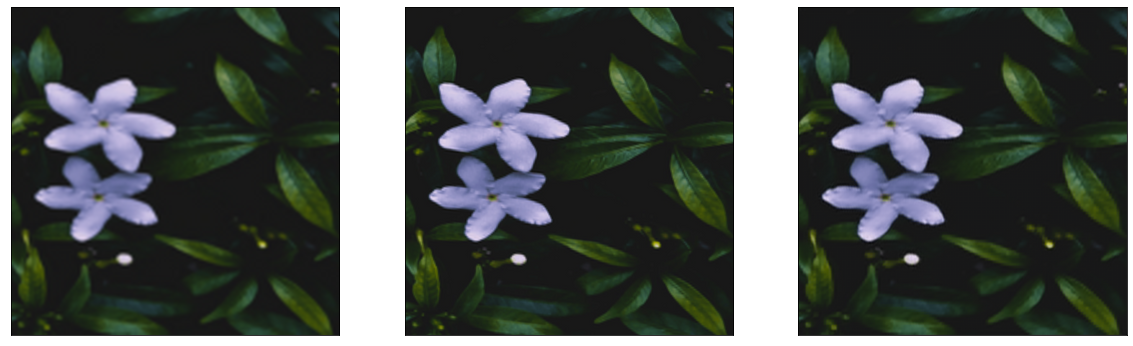

In [ ]:
this_time = time.time()
print('trying to load last saved generator weights...', end = ' ') 
try:
    with open(generator_weight_file, 'rb') as file:
        generator.set_weights(dill.load(file))
    print('success.')
except:
    print('failed.')
print('trying to load last saved generator optimizer weights...', end = ' ') 
try:
    with open(generator_optimizer_weight_file, 'rb') as file:
        generator.optimizer.set_weights(dill.load(file))
    print('success.')
except:
    print('failed.')

#X, Y = get_batch_generator(batch_size, height_lr, width_lr)
for real_epoch in range(epochs):
    #X, Y = get_batch_generator(batch_size, height_lr, width_lr)
    generator.fit(X, Y, epochs = steps_per_epoch, verbose = 0, callbacks = [generator_logging_callback], shuffle = True)
    
    print('trying to save generator weights...', end = ' ')
    try:
        with open(generator_weight_file, 'wb') as file:
            dill.dump(generator.get_weights(), file)
        print('success.')
    except:
        print('failed.')

    print('trying to save generator optimizer weights...', end = ' ')
    try:
        with open(generator_optimizer_weight_file, 'wb') as file:
            dill.dump(generator.optimizer.get_weights(), file)
        print('success.')
    except:
        print('failed.')

### try several speed and size optimization strategies

In [ ]:
#get layer weights
color_sep = generator.get_layer('color_sep').get_weights()
gray_filters = generator.get_layer('gray_filters').get_weights()
color_upsample = generator.get_layer('color_upsample').get_weights()
gray_upsample = generator.get_layer('gray_upsample').get_weights()
weights = {}

for x in range(15):
  weights["conv1_block{0}".format(x)] = generator.get_layer('conv1_block' + str(x)).get_weights()
  weights["conv2_block{0}".format(x)] = generator.get_layer('conv2_block' + str(x)).get_weights()
  weights["conv3_block{0}".format(x)] = generator.get_layer('conv3_block' + str(x)).get_weights()

In [ ]:
def build_generator_variation():
  inputs = Input(shape = (height_lr, width_lr, channels))
  normalized = inputs / 255
  gray = SeparableConv2D(1, 1, padding = 'same', name = 'color_sep', trainable = False)(normalized)
  color = normalized - gray
  
  gray = SeparableConv2D(16, kernel_size = 3, padding = 'same', activation = 'relu', name = 'gray_filters', trainable = False)(gray)
  
  for block in range (13):
    skip = gray
    att = gray = Conv2D(16, 3, activation = 'swish', strides = 1, padding = 'same', name = 'conv1_block' + str(block))(gray)
    gray = Conv2D(16, 3, strides = 1, padding = 'same', name = 'conv2_block' + str(block))(gray)
    attention = Conv2D(1, 3, activation = 'sigmoid', padding = 'same', name = 'conv3_block' + str(block))(att)
    gray = Multiply()([gray, attention])    
 
    gray = Add()([gray, skip])

  #gray = upsample4xGray(gray) #wait for tensorflow 2.3.0-rc0
  gray = Conv2DTranspose(1, 4, 4, padding = 'same', name = 'gray_upsample')(gray)

  #color = UpSampling2D(size = 4, interpolation = 'bilinear')(color) #wait for tensorflow 2.3.0-rc0
  color = Conv2DTranspose(3, 4, 4, padding = 'same', name = 'color_upsample')(color)
  outputs = Add()([color, gray])
  outputs = outputs * 255
  return Model(inputs = inputs, outputs = outputs)

with strategy.scope():
  generator = build_generator_variation()
  generator.compile(optimizer = Adam(gen_lr), loss = multi_loss)
  generator.summary()

In [ ]:
#transfer old weights
generator.get_layer('color_sep').set_weights(color_sep)
generator.get_layer('gray_filters').set_weights(gray_filters)
generator.get_layer('color_upsample').set_weights(color_upsample)
generator.get_layer('gray_upsample').set_weights(gray_upsample)

for x in range(13):
  generator.get_layer('conv1_block' + str(x)).set_weights(weights["conv1_block{0}".format(x)])
  generator.get_layer('conv2_block' + str(x)).set_weights(weights["conv2_block{0}".format(x)])
  generator.get_layer('conv3_block' + str(x)).set_weights(weights["conv3_block{0}".format(x)])

In [ ]:
#train to test
for real_epoch in range(epochs):
    X, Y = get_batch_generator(batch_size, height_lr, width_lr)
    generator.fit(X, Y, batch_size, epochs = steps_per_epoch + 1, verbose = 0, callbacks = [generator_logging_callback], shuffle = True)
    


### prune the model for faster inference

In [ ]:
epochs = 5 #Number of epochs to train
steps_per_epoch = 100 #How much iterations per epoch to train

In [ ]:
prune_low_magnitude = tfmot.sparsity.keras.prune_low_magnitude
pruning_params = {
      'pruning_schedule': tfmot.sparsity.keras.PolynomialDecay(initial_sparsity=0.10,
                                                               final_sparsity=0.4,
                                                               begin_step=0,
                                                               end_step=epochs)
}

with strategy.scope():
  model_for_pruning = prune_low_magnitude(generator, **pruning_params)
  model_for_pruning.compile(optimizer = Adam(gen_lr), loss = multi_loss)
  
  model_for_pruning.summary()

In [ ]:
this_time = time.time()
print('trying to load last saved weights...', end = ' ') 
try:
    with open(pruning_weight_file, 'rb') as file:
        model_for_pruning.set_weights(dill.load(file))
    print('success.')
except:
    print('failed.')

for real_epoch in range(epochs):
    X, Y = get_batch_generator(batch_size, height_lr, width_lr)
    model_for_pruning.fit(X, Y, batch_size, epochs = steps_per_epoch + 1, verbose = 1, callbacks = [tfmot.sparsity.keras.UpdatePruningStep()], shuffle = True)
    clear_output()
    print('trying to save weights...', end = ' ')
    try:
        with open(pruning_weight_file, 'wb') as file:
            dill.dump(model_for_pruning.get_weights(), file)
        print('success.')
    except:
        print('failed.')

In [ ]:
model_for_export = tfmot.sparsity.keras.strip_pruning(model_for_pruning)

### validate on complete picture

In [ ]:
img = Image.open('./DIV2K-sample.png').convert('L')
img = np.array(img)
img = img.astype(np.float32)

print('ground truth:')
display_image_in_actual_size(img)

#generator = build_generator(img.shape)

print('trying to load last saved weights...', end = ' ') 
try:
    with open(weight_file, 'rb') as file:
        generator.set_weights(dill.load(file))
    print('success.')
except:
    print('failed.')


print('superresolution:')
predicted = generator.predict(np.expand_dims((img), 0))
print(predicted.shape)
display_image_in_actual_size(predicted.squeeze(3))
predicted = Image.fromarray(predicted.astype(np.uint8))
'''
print('trying to save image as \'superresolution_result.png\'...', end = ' ')
try:
    predicted.save('superresolution_result.png', "PNG")
    print('success.')
except:
    print('failed.')
    pass
'''

###export to tensorflow.js

In [ ]:
generator.save('sr_tfjs.h5')
!pip install tensorflowjs
!tensorflowjs_converter --input_format=keras sr_tfjs.h5 model/
!ls -la
!zip -r model.zip model 
print('you can download model.zip from the menu...')